# v19 Training - XLM-RoBERTa-large with High-Quality Data

This notebook trains the v19 Korean-English cross-lingual SPLADE model.

## Key Features:
- **Model**: xlm-roberta-large (560M parameters)
- **Dataset**: v19_high_quality (~18K pairs, MUSE only, no wikidata)
- **Learning rate**: 2e-6
- **Epochs**: 10
- **Loss weights**: self=2.0, target=5.0, margin=3.0, negative=0.5, sparsity=0.005

In [1]:
import sys
from pathlib import Path

# Find project root
def find_project_root():
    """Find project root by looking for markers like pyproject.toml or src/"""
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [2]:
import json
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm

from src.model.splade_model import create_splade_model

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.10.0.dev20251109+cu130
CUDA available: True
GPU: NVIDIA GB10
GPU Memory: 128.5 GB


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


## 1. Configuration

In [3]:
# Training Configuration
CONFIG = {
    # Model
    "model_name": "xlm-roberta-large",
    "max_length": 64,

    # Data - high-quality only (no wikidata)
    "data_path": PROJECT_ROOT / "dataset" / "v19_high_quality" / "term_pairs.jsonl",

    # Training
    "batch_size": 32,
    "gradient_accumulation_steps": 4,
    "num_epochs": 10,
    "learning_rate": 2e-6,
    "warmup_ratio": 0.2,
    "max_grad_norm": 1.0,

    # Loss weights
    "lambda_self": 2.0,       # Korean preservation
    "lambda_target": 5.0,     # English activation
    "lambda_margin": 3.0,     # Margin loss
    "lambda_negative": 0.5,   # Non-target language suppression
    "lambda_sparsity": 0.005, # Sparsity regularization
    "target_margin": 2.0,

    # Mixed precision
    "use_fp16": True,

    # Output
    "output_dir": PROJECT_ROOT / "outputs" / "v19_xlm_large",
}

print("Training Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Training Configuration:
  model_name: xlm-roberta-large
  max_length: 64
  data_path: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v19_high_quality/term_pairs.jsonl
  batch_size: 32
  gradient_accumulation_steps: 4
  num_epochs: 10
  learning_rate: 2e-06
  warmup_ratio: 0.2
  max_grad_norm: 1.0
  lambda_self: 2.0
  lambda_target: 5.0
  lambda_margin: 3.0
  lambda_negative: 0.5
  lambda_sparsity: 0.005
  target_margin: 2.0
  use_fp16: True
  output_dir: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large


## 2. Helper Functions

In [4]:
def is_korean_char(c: str) -> bool:
    """Check if character is Korean."""
    return (
        "\uac00" <= c <= "\ud7a3"
        or "\u1100" <= c <= "\u11ff"
        or "\u3130" <= c <= "\u318f"
    )


def is_english_char(c: str) -> bool:
    """Check if character is English."""
    return c.isalpha() and c.isascii()


def is_non_target_token(token: str) -> bool:
    """Check if token is from non-target language (not Korean or English)."""
    clean = token.replace("\u2581", "").replace("##", "")  # Remove subword markers
    if not clean:
        return False

    has_korean = any(is_korean_char(c) for c in clean)
    has_english = any(is_english_char(c) for c in clean)

    if has_korean or has_english:
        return False

    # Check for other languages
    has_japanese = any(
        "\u3040" <= c <= "\u309f" or "\u30a0" <= c <= "\u30ff" for c in clean
    )
    has_cjk = any("\u4e00" <= c <= "\u9fff" for c in clean)
    has_cyrillic = any("\u0400" <= c <= "\u04ff" for c in clean)
    has_arabic = any("\u0600" <= c <= "\u06ff" for c in clean)
    has_thai = any("\u0e00" <= c <= "\u0e7f" for c in clean)
    has_greek = any("\u0370" <= c <= "\u03ff" for c in clean)

    return (
        has_japanese or has_cjk or has_cyrillic or has_arabic or has_thai or has_greek
    )

## 3. Dataset Class

In [5]:
class TermPairDataset(Dataset):
    """Dataset for Korean-English term pairs."""

    def __init__(self, data_path: Path, tokenizer, max_length: int = 64):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []

        print(f"Loading dataset from {data_path}...")

        with open(data_path, "r", encoding="utf-8") as f:
            for line in tqdm(f, desc="Loading data"):
                item = json.loads(line.strip())

                ko_term = item.get("ko", "")
                en_term = item.get("en", "")

                if not ko_term or not en_term:
                    continue

                # Tokenize Korean term
                ko_tokens = tokenizer.tokenize(ko_term)
                ko_token_ids = tokenizer.convert_tokens_to_ids(ko_tokens)
                ko_token_ids = [
                    tid for tid in ko_token_ids if tid != tokenizer.unk_token_id
                ]

                # Tokenize English term (lowercase)
                en_tokens = tokenizer.tokenize(en_term.lower())
                en_token_ids = tokenizer.convert_tokens_to_ids(en_tokens)
                en_token_ids = [
                    tid for tid in en_token_ids if tid != tokenizer.unk_token_id
                ]

                if ko_token_ids and en_token_ids:
                    self.data.append(
                        {
                            "ko_term": ko_term,
                            "en_term": en_term,
                            "ko_token_ids": ko_token_ids,
                            "en_token_ids": en_token_ids,
                        }
                    )

        print(f"Loaded {len(self.data):,} valid term pairs")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        encoding = self.tokenizer(
            item["ko_term"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "ko_token_ids": item["ko_token_ids"],
            "en_token_ids": item["en_token_ids"],
        }


def collate_fn(batch):
    """Custom collate function."""
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "ko_token_ids": [item["ko_token_ids"] for item in batch],
        "en_token_ids": [item["en_token_ids"] for item in batch],
    }

## 4. Loss Function

In [6]:
class TermLevelLoss(nn.Module):
    """Loss function for term-level cross-lingual training.
    
    Components:
    - Self loss: Preserve Korean term tokens
    - Target loss: Activate English translation tokens
    - Margin loss: Ensure minimum activation for English tokens
    - Negative loss: Suppress non-target language tokens
    """

    def __init__(self, target_margin: float = 2.0, non_target_ids: torch.Tensor = None):
        super().__init__()
        self.target_margin = target_margin
        self.non_target_ids = non_target_ids

    def forward(self, sparse_rep, ko_token_ids, en_token_ids):
        batch_size = sparse_rep.shape[0]
        device = sparse_rep.device

        self_loss = torch.tensor(0.0, device=device)
        target_loss = torch.tensor(0.0, device=device)
        margin_loss = torch.tensor(0.0, device=device)
        negative_loss = torch.tensor(0.0, device=device)

        n_valid = 0

        for i in range(batch_size):
            rep = sparse_rep[i]

            # Self loss: maximize activation of Korean tokens
            if ko_token_ids[i]:
                ko_ids = torch.tensor(ko_token_ids[i], device=device)
                ko_activations = rep[ko_ids]
                self_loss = self_loss - torch.log(ko_activations + 1e-8).mean()

            # Target loss: maximize activation of English tokens
            if en_token_ids[i]:
                en_ids = torch.tensor(en_token_ids[i], device=device)
                en_activations = rep[en_ids]
                target_loss = target_loss - torch.log(en_activations + 1e-8).mean()
                margin_loss = margin_loss + F.relu(
                    self.target_margin - en_activations
                ).mean()

            # Negative loss: suppress non-target language tokens
            if self.non_target_ids is not None:
                non_target_ids_device = self.non_target_ids.to(device)
                non_target_activations = rep[non_target_ids_device]
                negative_loss = negative_loss + F.relu(
                    non_target_activations - 0.1
                ).mean()

            n_valid += 1

        if n_valid > 0:
            self_loss = self_loss / n_valid
            target_loss = target_loss / n_valid
            margin_loss = margin_loss / n_valid
            negative_loss = negative_loss / n_valid

        return {
            "self": self_loss,
            "target": target_loss,
            "margin": margin_loss,
            "negative": negative_loss,
        }

## 5. Evaluation Function

In [7]:
# Test pairs for evaluation
TEST_PAIRS = [
    ("머신러닝", ["machine", "learning"], ["머신", "러닝"]),
    ("딥러닝", ["deep", "learning"], ["딥", "러닝"]),
    ("자연어처리", ["natural", "language", "processing"], ["자연어", "처리"]),
    ("인공지능", ["artificial", "intelligence"], ["인공", "지능"]),
    ("검색엔진", ["search", "engine"], ["검색", "엔진"]),
    ("데이터베이스", ["database"], ["데이터베이스"]),
    ("클라우드", ["cloud"], ["클라우드"]),
    ("서버", ["server"], ["서버"]),
    ("네트워크", ["network"], ["네트워크"]),
    ("추천시스템", ["recommend", "system"], ["추천", "시스템"]),
    ("추천", ["recommend", "recommendation"], ["추천"]),
    ("신경망", ["neural", "network"], ["신경망"]),
    ("강화학습", ["reinforcement", "learning"], ["강화", "학습"]),
    ("컴퓨터비전", ["computer", "vision"], ["컴퓨터", "비전"]),
    ("음성인식", ["speech", "recognition"], ["음성", "인식"]),
]


def evaluate_model(model, tokenizer, device, top_k=50):
    """Evaluate model on test pairs."""
    model.eval()

    ko_activated_total = 0
    en_activated_total = 0
    ko_expected_total = 0
    en_expected_total = 0

    with torch.no_grad():
        for ko_term, en_expected, ko_expected in TEST_PAIRS:
            encoding = tokenizer(
                ko_term,
                max_length=64,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )

            with autocast("cuda", enabled=CONFIG["use_fp16"]):
                sparse_rep, _ = model(
                    encoding["input_ids"].to(device),
                    encoding["attention_mask"].to(device),
                )

            sparse_rep = sparse_rep[0].float().cpu()
            top_indices = torch.topk(sparse_rep, k=top_k).indices.tolist()
            top_tokens = tokenizer.convert_ids_to_tokens(top_indices)
            top_tokens_set = set(top_tokens)

            # Check Korean preservation
            for ko in ko_expected:
                ko_toks = tokenizer.tokenize(ko)
                for tok in ko_toks:
                    ko_expected_total += 1
                    if tok in top_tokens_set:
                        ko_activated_total += 1

            # Check English activation
            for en in en_expected:
                en_toks = tokenizer.tokenize(en.lower())
                for tok in en_toks:
                    en_expected_total += 1
                    if tok in top_tokens_set:
                        en_activated_total += 1

    model.train()

    ko_rate = (
        ko_activated_total / ko_expected_total * 100 if ko_expected_total > 0 else 0
    )
    en_rate = (
        en_activated_total / en_expected_total * 100 if en_expected_total > 0 else 0
    )

    return ko_rate, en_rate

## 6. Initialize Components

In [8]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load tokenizer
print(f"\nLoading tokenizer: {CONFIG['model_name']}...")
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])
print(f"Vocab size: {tokenizer.vocab_size:,}")

Device: cuda

Loading tokenizer: xlm-roberta-large...
Vocab size: 250,002


In [9]:
# Build non-target language token ID list
print("Building non-target language token ID list...")
non_target_ids = []
for token_id in tqdm(range(tokenizer.vocab_size), desc="Scanning vocab"):
    token = tokenizer.convert_ids_to_tokens(token_id)
    if is_non_target_token(token):
        non_target_ids.append(token_id)
non_target_ids_tensor = torch.tensor(non_target_ids, dtype=torch.long)
print(f"Found {len(non_target_ids):,} non-target language tokens")

Building non-target language token ID list...


Scanning vocab:   0%|          | 0/250002 [00:00<?, ?it/s]

Found 76,320 non-target language tokens


In [10]:
# Load dataset
dataset = TermPairDataset(CONFIG["data_path"], tokenizer, CONFIG["max_length"])

dataloader = DataLoader(
    dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
    pin_memory=True,
)

print(f"\nDataset size: {len(dataset):,}")
print(f"Batches per epoch: {len(dataloader):,}")
print(f"Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")

Loading dataset from /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v19_high_quality/term_pairs.jsonl...


Loading data: 0it [00:00, ?it/s]

Loaded 18,470 valid term pairs

Dataset size: 18,470
Batches per epoch: 578
Effective batch size: 128


In [11]:
# Create model
print(f"\nCreating model: {CONFIG['model_name']}...")
model = create_splade_model(
    model_name=CONFIG["model_name"],
    use_idf=False,
    use_expansion=True,
    expansion_mode="mlm",
)
model = model.to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {n_params:,} ({n_params / 1e6:.1f}M)")


Creating model: xlm-roberta-large...


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Parameters: 560,142,482 (560.1M)


In [12]:
# Loss function
loss_fn = TermLevelLoss(
    target_margin=CONFIG["target_margin"], 
    non_target_ids=non_target_ids_tensor
)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=CONFIG["learning_rate"], 
    weight_decay=0.01
)

# Scheduler
total_steps = (
    len(dataloader) * CONFIG["num_epochs"] // CONFIG["gradient_accumulation_steps"]
)
warmup_steps = int(total_steps * CONFIG["warmup_ratio"])

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps
)

print(f"Total optimization steps: {total_steps:,}")
print(f"Warmup steps: {warmup_steps:,}")

# Mixed precision scaler
scaler = GradScaler("cuda", enabled=CONFIG["use_fp16"])

# Create output directory
CONFIG["output_dir"].mkdir(parents=True, exist_ok=True)
print(f"Output directory: {CONFIG['output_dir']}")

Total optimization steps: 1,445
Warmup steps: 289
Output directory: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large


## 7. Initial Evaluation

In [13]:
# Evaluate before training
ko_rate, en_rate = evaluate_model(model, tokenizer, device)
print(f"Initial Performance:")
print(f"  Korean Preservation: {ko_rate:.1f}%")
print(f"  English Activation: {en_rate:.1f}%")
print(f"  Combined Score: {ko_rate + en_rate:.1f}")

Initial Performance:
  Korean Preservation: 56.8%
  English Activation: 9.1%
  Combined Score: 65.8


## 8. Training Loop

In [14]:
# Training variables
history = []
best_score = 0
global_step = 0

print("=" * 70)
print("STARTING TRAINING")
print("=" * 70)

STARTING TRAINING


In [15]:
for epoch in range(CONFIG["num_epochs"]):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{CONFIG['num_epochs']}")
    print(f"{'='*70}")
    
    model.train()
    epoch_losses = defaultdict(float)
    optimizer.zero_grad()

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")

    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        with autocast("cuda", enabled=CONFIG["use_fp16"]):
            sparse_rep, _ = model(input_ids, attention_mask)

            losses = loss_fn(
                sparse_rep,
                batch["ko_token_ids"],
                batch["en_token_ids"],
            )

            sparsity_loss = sparse_rep.mean()

            total_loss = (
                CONFIG["lambda_self"] * losses["self"]
                + CONFIG["lambda_target"] * losses["target"]
                + CONFIG["lambda_margin"] * losses["margin"]
                + CONFIG["lambda_negative"] * losses["negative"]
                + CONFIG["lambda_sparsity"] * sparsity_loss
            )

            total_loss = total_loss / CONFIG["gradient_accumulation_steps"]

        scaler.scale(total_loss).backward()

        epoch_losses["total"] += total_loss.item() * CONFIG["gradient_accumulation_steps"]
        epoch_losses["self"] += losses["self"].item()
        epoch_losses["target"] += losses["target"].item()
        epoch_losses["margin"] += losses["margin"].item()
        epoch_losses["negative"] += losses["negative"].item()

        if (batch_idx + 1) % CONFIG["gradient_accumulation_steps"] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), CONFIG["max_grad_norm"]
            )
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
            global_step += 1

        if (batch_idx + 1) % 100 == 0:
            progress_bar.set_postfix(
                {
                    "loss": f"{epoch_losses['total'] / (batch_idx + 1):.4f}",
                    "tgt": f"{epoch_losses['target'] / (batch_idx + 1):.4f}",
                    "step": global_step,
                }
            )

    # Calculate average losses
    n_batches = len(dataloader)
    for key in epoch_losses:
        epoch_losses[key] /= n_batches

    history.append(dict(epoch_losses))

    # Evaluate
    ko_rate, en_rate = evaluate_model(model, tokenizer, device)
    combined_score = ko_rate + en_rate

    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Total Loss: {epoch_losses['total']:.4f}")
    print(f"  Self Loss: {epoch_losses['self']:.4f}")
    print(f"  Target Loss: {epoch_losses['target']:.4f}")
    print(f"  Korean Preservation: {ko_rate:.1f}%")
    print(f"  English Activation: {en_rate:.1f}%")
    print(f"  Combined Score: {combined_score:.1f}")

    # Save checkpoint
    checkpoint_path = CONFIG["output_dir"] / f"checkpoint_epoch{epoch + 1}.pt"
    torch.save(
        {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "losses": dict(epoch_losses),
            "ko_rate": ko_rate,
            "en_rate": en_rate,
            "config": {
                k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()
            },
        },
        checkpoint_path,
    )
    print(f"  Saved: {checkpoint_path.name}")

    # Save best model
    if combined_score > best_score:
        best_score = combined_score
        best_path = CONFIG["output_dir"] / "best_model.pt"
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "ko_rate": ko_rate,
                "en_rate": en_rate,
                "combined_score": combined_score,
                "config": {
                    k: str(v) if isinstance(v, Path) else v
                    for k, v in CONFIG.items()
                },
            },
            best_path,
        )
        print(f"  *** New best model! Score: {combined_score:.1f} (KO:{ko_rate:.1f}% + EN:{en_rate:.1f}%) ***")


Epoch 1/10


Epoch 1:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 1 Summary:
  Total Loss: -7.7351
  Self Loss: -1.3584
  Target Loss: -1.3248
  Korean Preservation: 21.6%
  English Activation: 3.0%
  Combined Score: 24.7
  Saved: checkpoint_epoch1.pt
  *** New best model! Score: 24.7 (KO:21.6% + EN:3.0%) ***

Epoch 2/10


Epoch 2:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 2 Summary:
  Total Loss: -8.9287
  Self Loss: -1.4548
  Target Loss: -1.4444
  Korean Preservation: 43.2%
  English Activation: 18.2%
  Combined Score: 61.4
  Saved: checkpoint_epoch2.pt
  *** New best model! Score: 61.4 (KO:43.2% + EN:18.2%) ***

Epoch 3/10


Epoch 3:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 3 Summary:
  Total Loss: -9.6999
  Self Loss: -1.4282
  Target Loss: -1.4084
  Korean Preservation: 59.5%
  English Activation: 24.2%
  Combined Score: 83.7
  Saved: checkpoint_epoch3.pt
  *** New best model! Score: 83.7 (KO:59.5% + EN:24.2%) ***

Epoch 4/10


Epoch 4:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 4 Summary:
  Total Loss: -9.8323
  Self Loss: -1.4451
  Target Loss: -1.4193
  Korean Preservation: 64.9%
  English Activation: 39.4%
  Combined Score: 104.3
  Saved: checkpoint_epoch4.pt
  *** New best model! Score: 104.3 (KO:64.9% + EN:39.4%) ***

Epoch 5/10


Epoch 5:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 5 Summary:
  Total Loss: -9.8806
  Self Loss: -1.4523
  Target Loss: -1.4244
  Korean Preservation: 70.3%
  English Activation: 45.5%
  Combined Score: 115.7
  Saved: checkpoint_epoch5.pt
  *** New best model! Score: 115.7 (KO:70.3% + EN:45.5%) ***

Epoch 6/10


Epoch 6:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 6 Summary:
  Total Loss: -9.9101
  Self Loss: -1.4567
  Target Loss: -1.4276
  Korean Preservation: 73.0%
  English Activation: 45.5%
  Combined Score: 118.4
  Saved: checkpoint_epoch6.pt
  *** New best model! Score: 118.4 (KO:73.0% + EN:45.5%) ***

Epoch 7/10


Epoch 7:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 7 Summary:
  Total Loss: -9.9299
  Self Loss: -1.4596
  Target Loss: -1.4298
  Korean Preservation: 70.3%
  English Activation: 45.5%
  Combined Score: 115.7
  Saved: checkpoint_epoch7.pt

Epoch 8/10


Epoch 8:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 8 Summary:
  Total Loss: -9.9426
  Self Loss: -1.4615
  Target Loss: -1.4312
  Korean Preservation: 73.0%
  English Activation: 45.5%
  Combined Score: 118.4
  Saved: checkpoint_epoch8.pt

Epoch 9/10


Epoch 9:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 9 Summary:
  Total Loss: -9.9507
  Self Loss: -1.4627
  Target Loss: -1.4321
  Korean Preservation: 70.3%
  English Activation: 42.4%
  Combined Score: 112.7
  Saved: checkpoint_epoch9.pt

Epoch 10/10


Epoch 10:   0%|          | 0/578 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Epoch 10 Summary:
  Total Loss: -9.9547
  Self Loss: -1.4633
  Target Loss: -1.4325
  Korean Preservation: 70.3%
  English Activation: 42.4%
  Combined Score: 112.7
  Saved: checkpoint_epoch10.pt


## 9. Save Final Model

In [16]:
# Save final model
final_path = CONFIG["output_dir"] / "final_model.pt"
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "config": {
            k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()
        },
        "history": history,
    },
    final_path,
)

# Save training history
with open(CONFIG["output_dir"] / "training_history.json", "w") as f:
    json.dump(history, f, indent=2)

print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)
print(f"Final model saved: {final_path}")
print(f"Best combined score: {best_score:.1f}")


TRAINING COMPLETE
Final model saved: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large/final_model.pt
Best combined score: 118.4


## 10. Training Summary

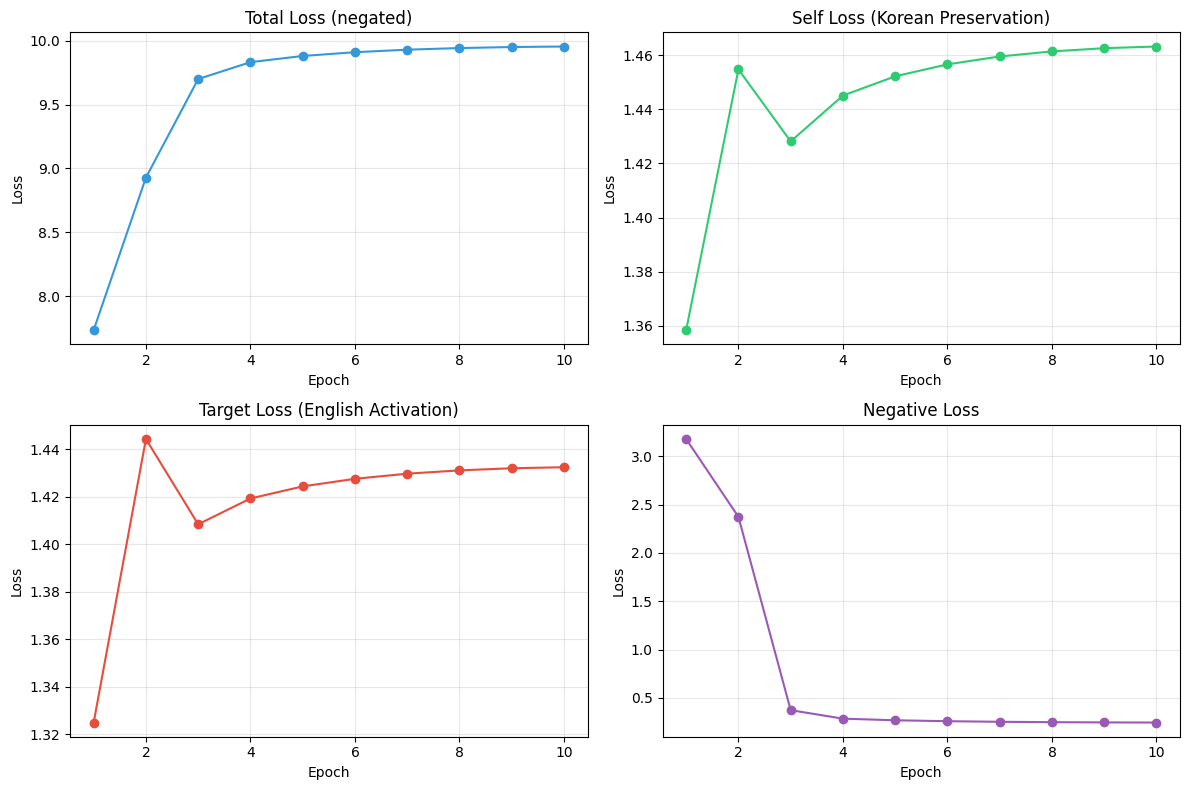

Training curves saved to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/outputs/v19_xlm_large/training_curves.png


In [17]:
import matplotlib.pyplot as plt

# Plot training curves
if history:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    epochs = range(1, len(history) + 1)

    # Total loss
    axes[0, 0].plot(epochs, [-h['total'] for h in history], '-o', color='#3498db')
    axes[0, 0].set_title('Total Loss (negated)')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)

    # Self loss
    axes[0, 1].plot(epochs, [-h['self'] for h in history], '-o', color='#2ecc71')
    axes[0, 1].set_title('Self Loss (Korean Preservation)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)

    # Target loss
    axes[1, 0].plot(epochs, [-h['target'] for h in history], '-o', color='#e74c3c')
    axes[1, 0].set_title('Target Loss (English Activation)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)

    # Negative loss
    axes[1, 1].plot(epochs, [h['negative'] for h in history], '-o', color='#9b59b6')
    axes[1, 1].set_title('Negative Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(CONFIG["output_dir"] / "training_curves.png", dpi=150)
    plt.show()
    
    print(f"Training curves saved to: {CONFIG['output_dir'] / 'training_curves.png'}")

## Next Steps

After training completes:

1. **Run inference tests** using `01_inference_test.ipynb`
2. **Analyze results** and compare with previous versions
3. **Fine-tune hyperparameters** if needed:
   - Adjust loss weights for better Korean/English balance
   - Try different learning rates
   - Experiment with dataset composition